In [1]:
import os
import sys

import logging
import re
import pathlib

import datetime

import numpy as np
import pandas as pd
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

from pyplink import PyPlink
import seaborn as sns

import statsmodels.api as sm

import matplotlib.patches as patches
import matplotlib

from basic_tools import *

"""

jupyter nbconvert 5_association.ipynb --to script
python 5_association.py albumin 2 0

"""

'\n\njupyter nbconvert 5_association.ipynb --to script\npython 5_association.py albumin 2 0\n\n'

In [2]:
plink_KCHIP_HLA_AA_SNP_1000G=PyPlink(plink_KCHIP_HLA_AA_SNP_1000G_path)
plink_KCHIP_HLA_AA_SNP_1000G_fam=plink_KCHIP_HLA_AA_SNP_1000G.get_fam().astype({'fid':str,'iid':str}).rename(columns={'fid':'FID','iid':'IID'})
plink_KCHIP_HLA_AA_SNP_1000G_bim=plink_KCHIP_HLA_AA_SNP_1000G.get_bim()

In [3]:
#gene_bed_path='data/mart_export.txt'
#gene_bed=pd.read_csv(gene_bed_path,sep='\t')

#ENSG00000206337

In [4]:
#gene_bed[gene_bed['Gene stable ID']=='ENSG00000206337']

In [5]:
gene_bed_path='data/mart_export.txt'
gene_bed=pd.read_csv(gene_bed_path,sep='\t')
gene_bed=gene_bed.drop(columns='Exon stable ID')
gene_bed=gene_bed[(gene_bed['Gene start (bp)']>=plink_KCHIP_HLA_AA_SNP_1000G_bim.pos.min())&(gene_bed['Gene end (bp)']<=plink_KCHIP_HLA_AA_SNP_1000G_bim.pos.max())]
gene_bed=gene_bed.merge(right=pd.read_csv('data/mart_export_grch38.txt',sep='\t')[['Gene stable ID','Gene start (bp)','Gene end (bp)']].rename(columns=(lambda x:x+'38')),left_on='Gene stable ID',right_on='Gene stable ID38',how='left',)

gene_bed=gene_bed[(gene_bed['Transcript type']=='protein_coding')]
gene_bed=gene_bed[~gene_bed.duplicated(['Gene name','Gene start (bp)','Gene end (bp)'])]
print(gene_bed.shape)
gene_bed=gene_bed[~gene_bed.duplicated(['Gene name'])]
print(gene_bed.shape)

print(gene_bed.shape)

gene_assign=plink_KCHIP_HLA_AA_SNP_1000G_bim[['pos']]

for idx,row in gene_bed.iterrows():
    gene_assign[row['Gene name']]=0
    
for idx,row in gene_bed.iterrows():    
    gene_assign[row['Gene name']][(gene_assign['pos']>=row['Gene start (bp)'])&(gene_assign['pos']<=row['Gene end (bp)'])]=1

#gene_assign.columns=gene_assign.columns.str.replace('HLA-','HLA_')        
    
HLA_names=np.unique([i[0].split('_')[1] for i in plink_KCHIP_HLA_AA_SNP_1000G_bim[plink_KCHIP_HLA_AA_SNP_1000G_bim.index.str.contains('HLA_')].index.str.split('*')])

for HLA_name in HLA_names:
    gene_select=gene_assign[gene_assign.index.str.contains('HLA_'+HLA_name)|gene_assign.index.str.contains('SNPS_'+HLA_name)|gene_assign.index.str.contains('AA_'+HLA_name)]#print(gene_select.sort_values('pos').iloc[0],gene_select.sort_values('pos').iloc[-1])
    HLA_name='HLA-{}'.format(HLA_name)
    gene_assign[HLA_name][(gene_assign['pos']>=gene_select['pos'].min())&(gene_assign['pos']<=gene_select['pos'].max())]=1 

(209, 33)
(207, 33)
(207, 33)


/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
#gene_bed38[['Gene stable ID','Gene start (bp)','Gene end (bp)']].rename(columns=lambda x:x+'aa')

In [7]:
#gene_bed38[['Gene stable ID','Gene start (bp)','Gene end (bp)']].rename

In [8]:
catalog=pd.read_csv('data/ebi_alternative_0708.tsv',sep='\t')
catalog['DISEASE/TRAIT']=catalog['DISEASE/TRAIT'].str.lower()
catalog['MAPPED_TRAIT']=catalog['MAPPED_TRAIT'].str.lower()
catalog_chr6=catalog[catalog['CHR_ID']=='6']
catalog_chr6['CHR_POS']=catalog_chr6['CHR_POS'].astype(int)
catalog_chr6.columns

catalog_chr6_short=catalog_chr6.drop(columns=['DATE ADDED TO CATALOG','REPLICATION SAMPLE SIZE','DATE','REGION','FIRST AUTHOR','JOURNAL','CHR_ID','LINK','MERGED','RISK ALLELE FREQUENCY','PVALUE_MLOG','STRONGEST SNP-RISK ALLELE','95% CI (TEXT)','OR or BETA','PLATFORM [SNPS PASSING QC]','MAPPED_TRAIT_URI','GENOTYPING TECHNOLOGY','STUDY ACCESSION'])
catalog_chr6_short=catalog_chr6_short[(catalog_chr6_short['CHR_POS'].astype(int)>plink_KCHIP_HLA_AA_SNP_1000G_bim.pos.min()) & (catalog_chr6_short['CHR_POS']<plink_KCHIP_HLA_AA_SNP_1000G_bim.pos.max())]

len(catalog_chr6_short['DISEASE/TRAIT'].unique()),len(catalog_chr6_short['MAPPED_TRAIT'].unique())

catalog_chr6_short=catalog_chr6_short[catalog_chr6_short['P-VALUE'].astype(float)<5e-8]

japan_data=pd.read_csv('data/japan.tsv',sep='\t',index_col=0)
japan_data['DISEASE/TRAIT']=japan_data['DISEASE/TRAIT'].str.lower()
catalog_chr6_short=pd.concat([catalog_chr6_short,japan_data])

#catalog_chr6_short['GENE_CUSTOM'][(catalog_chr6_short['PUBMEDID']==30692682)]=catalog_chr6_short['CHR_POS'][(catalog_chr6_short['PUBMEDID']==30692682)].map(lambda x: pos_to_gene(x,mode='37'))    

#catalog_chr6_short[(catalog_chr6_short['PUBMEDID']==30692682)]#['GENE_CUSTOM']

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (9,11,12,13,23,27,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [ ]:
catalog_chr6_short['MAPPED_TRAIT'].unique()

In [10]:
#japan_data.sort_values('P-VALUE')

In [ ]:
def pos_to_gene(pos,mode='38'):
    if mode=='38':
        start='Gene start (bp)38'
        end='Gene end (bp)38'
    elif mode=='37':
        start='Gene start (bp)'
        end='Gene end (bp)'    
    else:
        raise
        
    gene_bed_select=gene_bed[(gene_bed[start]<pos) & (pos<gene_bed[end])]
    if gene_bed_select.shape[0]>0:
        return ','.join(gene_bed_select['Gene name'])
    
    front_back=[]
    gene_bed_select=gene_bed[gene_bed[end]<pos]
    gene_bed_select.loc[:,'dist']=(gene_bed_select[end]-pos).abs()
    if gene_bed_select.shape[0]>0:
        front_back.append(gene_bed_select.sort_values('dist')['Gene name'].iloc[0])
    
    gene_bed_select=gene_bed[gene_bed[start]>pos]
    gene_bed_select.loc[:,'dist']=(gene_bed_select[start]-pos).abs()
    if gene_bed_select.shape[0]>0:
        front_back.append(gene_bed_select.sort_values('dist')['Gene name'].iloc[0])
        
    return ','.join(front_back)

catalog_chr6_short['GENE_CUSTOM']=np.nan
catalog_chr6_short['GENE_CUSTOM'][(catalog_chr6_short['PUBMEDID']!=30692682)]=catalog_chr6_short['CHR_POS'][(catalog_chr6_short['PUBMEDID']!=30692682)].map(lambda x: pos_to_gene(x,mode='38'))    
catalog_chr6_short['GENE_CUSTOM'][(catalog_chr6_short['PUBMEDID']==30692682)]=catalog_chr6_short['CHR_POS'][(catalog_chr6_short['PUBMEDID']==30692682)].map(lambda x: pos_to_gene(x,mode='37'))    

In [14]:
gene_unique=gene_bed['Gene name'].unique()
def gene_bed_match(gene):
    if type(gene)==float:
        return ''
    gene_list=[i.strip() for i in gene.split(',')]
    return ','.join(list(filter(lambda x: x in gene_unique,gene_list)))
    
catalog_chr6_short['REPORTED_GENE_CUSTOM']=catalog_chr6_short['REPORTED GENE(S)'].map(gene_bed_match)
catalog_chr6_short['GENE_CUSTOM_REPORTED_GENE_CUSTOM']=catalog_chr6_short[['GENE_CUSTOM','REPORTED_GENE_CUSTOM']].apply(lambda x: np.unique((x[0]+','+x[1]).strip(',').split(',')),axis=1)

In [15]:
catalog_chr6_short.to_csv('data/ebi_alternative_0708_munged.tsv',sep='\t')

In [16]:
result_all=pd.read_csv('data/result_concat_3_top_gene_annot.tsv',sep='\t')
#phenotype_name_significant_list=result_all[result_all['P_significant']==1]['phenotype_name'].unique()

In [17]:
result_all[result_all['phenotype_name']=='t2_diabetes']

,Unnamed: 0,phenotype_name,samples(case/control),step,condition,marker_name,note,term,POS,A1,...,coef,std,chisq,df,nobs,P,P_significant,gene_genehow,gene,genehow
139,68706,t2_diabetes,8662/78950,1,NaN,6:34185749_C/T,unphased biallelic,ADD,34185749.0,C,...,-0.164752,0.024053,NaN,NaN,87612,7.403820e-12,1,"('HMGA1', 'strong_LD')",HMGA1,strong_LD
140,35419,t2_diabetes,8662/78950,2,6:34185749_C/T,6:32181182_G/A,unphased biallelic,ADD,32181182.0,A,...,-0.092008,0.018700,NaN,NaN,87612,8.652720e-07,0,NaN,NaN,NaN


In [18]:
phenotype_catalog_mapping={
    'FEV_predicted':{'include_list':['fev','expiratory'],'exclude_list':['ratio','fever']},
    'FVC_predicted':{'include_list':['fvc','vital'],'exclude_list':['ratio']},
    'albumin':{'include_list':['serum albumin level','albumin'],'exclude_list':['non-albumin','ratio','diabetes']},
    'allergic_disease':{'include_list':['allerg','atopic derma'],'exclude_list':[]},
    'alt':{'include_list':['alanine'],'exclude_list':['cancer']},
    'ast':{'include_list':['aspartat'],'exclude_list':['cancer']},
    'blood_in_urine':{'include_list':['hematuria','uri'],'exclude_list':[]},
    'bmi':{'include_list':['bmi','body mass index'],'exclude_list':['adjusted','blood','urate','bipolar','multiple','physical','smok']},
    'bun':{'include_list':['bun','nitr'],'exclude_list':[]},
    'creatinine':{'include_list':['creatinine'],'exclude_list':['ratio']},
    't2_diabetes':{'include_list':['diabetes'],'exclude_list':[',','medica','type 1']},
    'diastolic_blood_pressure':{'include_list':['diastolic'],'exclude_list':['time']},
    'systolic_blood_pressure':{'include_list':['systolic'],'exclude_list':['time']},
    'grip_strength':{'include_list':['grip'],'exclude_list':['time']},
    'hba1c':{'include_list':['a1c'],'exclude_list':[]},
    'hdl_cholesterol':{'include_list':['hdl','high density'],'exclude_list':[]},
    'height':{'include_list':['height'],'exclude_list':['growth']},
    'hematocrit':{'include_list':['hematocrit','hema'],'exclude_list':['growth']},
    'hemoglobin':{'include_list':['hemoglobin'],'exclude_list':['a1c']},
    'hip_circumference':{'include_list':['hip'],'exclude_list':['ratio','knee']},
    'hscrp':{'include_list':['hscrp','c-reactive'],'exclude_list':['low','or']},
    'hyperlipidemia':{'include_list':['cholesterol'],'exclude_list':[]},
    'hypertension':{'include_list':['hypertension'],'exclude_list':['to']},
    'mch':{'include_list':['corpuscular','mch'],'exclude_list':['volume','concentration','mchc']},
    'mcv':{'include_list':['corpuscular','mcv'],'exclude_list':['hemo']},
    'menopause_age':{'include_list':['menopause'],'exclude_list':[]},
    'platelet':{'include_list':['platelet'],'exclude_list':['trait','width','crit']},
    'protein_in_blood':{'include_list':['protein'],'exclude_list':['immuno','cholesterol','quantita','disease','wheat']},
    'pulse':{'include_list':['pulse'],'exclude_list':[]},
    'rbc':{'include_list':['red','erythrocy'],'exclude_list':['medication','width','lobe','tissue']},
    'thyroid_disease':{'include_list':['thyroi'],'exclude_list':['diabetes','medi','drug']},
    'total_cholesterol':{'include_list':['cholesterol'],'exclude_list':[]},
    'triglyceride':{'include_list':['triglycer'],'exclude_list':[]},
    'wbc':{'include_list':['white'],'exclude_list':['micro','wine']},
    'weight':{'include_list':['weight'],'exclude_list':['urate']},
}

In [19]:
catalog_chr6_short[catalog_chr6_short['DISEASE/TRAIT'].str.contains('nitr')|catalog_chr6_short['MAPPED_TRAIT'].str.contains('nitr')]

,Allele,CHR_POS,CNV,CONTEXT,Category,DISEASE/TRAIT,DOWNSTREAM_GENE_DISTANCE,DOWNSTREAM_GENE_ID,INITIAL SAMPLE SIZE,INTERGENIC,...,REPORTED GENE(S),SNPS,SNP_GENE_IDS,SNP_ID_CURRENT,STUDY,UPSTREAM_GENE_DISTANCE,UPSTREAM_GENE_ID,GENE_CUSTOM,REPORTED_GENE_CUSTOM,GENE_CUSTOM_REPORTED_GENE_CUSTOM


In [20]:
for phenotype_name in result_all[result_all['P_significant']==1]['phenotype_name'].unique():
    if phenotype_name!='glucose_in_blood':
        continue
    print(phenotype_name)
    
    catalog_temp=catalog_chr6_short.copy()
    catalog_check=np.zeros(catalog_temp.shape[0]).astype(bool)
    for include in phenotype_catalog_mapping[phenotype_name]['include_list']:
        catalog_check=catalog_check|(catalog_temp['DISEASE/TRAIT'].str.contains(include)|catalog_temp['MAPPED_TRAIT'].str.contains(include))
    #print(temp[['DISEASE/TRAIT','MAPPED_TRAIT']])
    for exclude in phenotype_catalog_mapping[phenotype_name]['exclude_list']:
        catalog_check=catalog_check&(~(catalog_temp['DISEASE/TRAIT'].str.contains(exclude)|catalog_temp['MAPPED_TRAIT'].str.contains(exclude)))
    
    print(catalog_temp[catalog_check][['PUBMEDID','DISEASE/TRAIT','MAPPED_TRAIT']])
    #or i in catalog_temp[catalog_check][['DISEASE/TRAIT','MAPPED_TRAIT']].iterrows():
    #   print(i[1].values)

In [21]:
for i in catalog_temp[catalog_check][['DISEASE/TRAIT','MAPPED_TRAIT']].iterrows():
    print(i[1].values)

NameError: name 'catalog_temp' is not defined

In [118]:
#catalog_chr6_short[catalog_chr6_short['PUBMEDID']==25751624]

In [119]:
 &(result_all_pub['step']==1)

SyntaxError: invalid syntax (<ipython-input-119-baa8f17de265>, line 1)

In [22]:
phenotype_info=pd.read_csv('data/phenotype_pubname.tsv',sep='\t',index_col=0)

In [23]:
result_all_pub=result_all.copy()
result_all_pub['No. signals']=result_all_pub['phenotype_name'].map(lambda x: result_all[(result_all['P_significant']==1) & (result_all['phenotype_name']==x)].shape[0])
result_all_pub=result_all_pub[(result_all_pub['P_significant']==1)]

In [24]:
result_all_pub['phenotype_category']=phenotype_info.loc[result_all_pub['phenotype_name']]['phenotype_category'].values
result_all_pub['phenotype_type']=phenotype_info.loc[result_all_pub['phenotype_name']]['phenotype_type'].values
result_all_pub['phenotype_name_publication']=phenotype_info.loc[result_all_pub['phenotype_name']]['phenotype_name_publication'].values

In [25]:
result_all_pub['A1/A2']=result_all_pub['A1']+'/'+result_all_pub['A2']

In [26]:
#result_all_pub_save[result_all_pub['phenotype_name']=='t2_diabetes']

In [ ]:
result_all_pub

In [ ]:
result_all_pub.columns

In [ ]:
result_all_pub_save=result_all_pub.copy()

In [ ]:
result_all_pub_save['']=result_all_pub_save['A1']+'/'+result_all_pub_save['A2']

In [ ]:
result_all_pub_step1=result_all_pub[result_all_pub['step']==1]

In [ ]:
result_all_pub_step1_save=result_all_pub_step1[['phenotype_type','phenotype_category','phenotype_name_publication','samples(case/control)',
       'No.independent signals', 'marker_name', 'POS', 'A1', 'A2','gene','A1_freq_case', 'A1_freq_control','coef','std', 'chisq', 'df', 'P']]

In [ ]:
result_all_pub_step1_save.sort_values(['phenotype_type','phenotype_category']).to_csv("result_pub_significant_step1.tsv",sep='\t')

In [ ]:
result_all_pub.columns.difference(result_all_pub_step1_save.columns)

In [ ]:
result_all_pub_save=result_all_pub[['phenotype_type','phenotype_category','phenotype_name_publication','samples(case/control)',
       'step', 'marker_name', 'POS', 'A1', 'A2','gene','A1_freq_case', 'A1_freq_control','coef','std', 'chisq', 'df', 'P']]

In [ ]:
result_all_pub_save.sort_values(['phenotype_type','phenotype_category']).to_csv("result_pub_significant_stepall.tsv",sep='\t')

In [ ]:
#result_all_pub_save.sort_values('phenotype_category').sort_values('phenotype_type')

In [ ]:
#result_all_pub_save.to_csv("result_pub_significant_step1.tsv",sep='\t')
#result_all_pub_save

# Novelty check

In [38]:
#catalog_temp['GENE_CUSTOM_REPORTED_GENE_CUSTOM']#.values#+[]

In [30]:
novelty_check_list=[]

for phenotype_name in result_all[result_all['P_significant']==1]['phenotype_name'].unique():   
    #print('-----------------------')
    if phenotype_name!='FEV_predicted':
        pass#continue
    
    our_temp=result_all[(result_all['P_significant']==1)&(result_all['phenotype_name']==phenotype_name)]

    catalog_temp=catalog_chr6_short.copy()
    catalog_check=np.zeros(catalog_temp.shape[0]).astype(bool)
    for include in phenotype_catalog_mapping[phenotype_name]['include_list']:
        catalog_check=catalog_check|(catalog_temp['DISEASE/TRAIT'].str.contains(include)|catalog_temp['MAPPED_TRAIT'].str.contains(include))
    #print(temp[['DISEASE/TRAIT','MAPPED_TRAIT']])
    for exclude in phenotype_catalog_mapping[phenotype_name]['exclude_list']:
        catalog_check=catalog_check&(~(catalog_temp['DISEASE/TRAIT'].str.contains(exclude)|catalog_temp['MAPPED_TRAIT'].str.contains(exclude)))

    catalog_temp=catalog_temp[catalog_check][['PUBMEDID','DISEASE/TRAIT','MAPPED_TRAIT','SNPS','CHR_POS','REPORTED GENE(S)','GENE_CUSTOM_REPORTED_GENE_CUSTOM']]#['CHR_POS'])#['GENE_CUSTOM_REPORTED_GENE_CUSTOM'])
    catalog_temp['genehow']='reported_gene+on_gene,nearest' 
    
    #print(phenotype_name,catalog_temp.shape,catalog_temp)
    is_novel=lambda gene: ('-' if len(set(gene.split(',')).intersection(set(np.unique(np.concatenate(catalog_temp['GENE_CUSTOM_REPORTED_GENE_CUSTOM'].values)))))>0 else 'novel') if catalog_temp.shape[0]>0 else 'novel'
        
    our_temp=our_temp[['marker_name','POS','gene','genehow']].rename(columns={'marker_name':'SNPS','POS':'CHR_POS','gene':'GENE_CUSTOM_REPORTED_GENE_CUSTOM'})
    our_temp['PUBMEDID']='OUR_RESULT'
    our_temp['novelty']=our_temp['GENE_CUSTOM_REPORTED_GENE_CUSTOM'].map(is_novel)

    
    our_catalog_concat=pd.concat([our_temp,catalog_temp])
    our_catalog_concat['phenotype_name']=phenotype_name
    our_catalog_concat=our_catalog_concat[['phenotype_name','PUBMEDID','DISEASE/TRAIT','MAPPED_TRAIT','SNPS','CHR_POS','REPORTED GENE(S)','GENE_CUSTOM_REPORTED_GENE_CUSTOM','genehow','novelty']]
    
    novelty_check_list.append(our_catalog_concat)
    

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [31]:
novelty_check_df=pd.concat(novelty_check_list)

In [32]:
#novelty_check_df

In [33]:
novelty_check_df['phenotype_category']=phenotype_info.loc[novelty_check_df['phenotype_name']]['phenotype_category'].values
novelty_check_df['phenotype_type']=phenotype_info.loc[novelty_check_df['phenotype_name']]['phenotype_type'].values
novelty_check_df['phenotype_name_publication']=phenotype_info.loc[novelty_check_df['phenotype_name']]['phenotype_name_publication'].values

In [34]:
#novelty_check_df[(novelty_check_df['PUBMEDID']=='OUR_RESULT')&(novelty_check_df['novelty']=='novel')]

In [35]:
#novelty_check_df[(novelty_check_df['PUBMEDID']=='OUR_RESULT')]

In [36]:
novelty_check_df.columns

Index(['phenotype_name', 'PUBMEDID', 'DISEASE/TRAIT', 'MAPPED_TRAIT', 'SNPS',
       'CHR_POS', 'REPORTED GENE(S)', 'GENE_CUSTOM_REPORTED_GENE_CUSTOM',
       'genehow', 'novelty', 'phenotype_category', 'phenotype_type',
       'phenotype_name_publication'],
      dtype='object')

In [39]:
pd.concat(novelty_check_list)['GENE_CUSTOM_REPORTED_GENE_CUSTOM'].iloc[1]

array(['ZKSCAN3', 'ZSCAN31'], dtype='<U7')

In [40]:
#novelty_check_list

In [41]:
novelty_check_df.sort_values(['phenotype_type','phenotype_category']).to_csv('data/result_concat_4_top_novelty_check.tsv',sep='\t')

In [42]:
novelty_check_df[['phenotype_type', 'phenotype_category', 'phenotype_name_publication',
        'PUBMEDID', 'DISEASE/TRAIT', 'MAPPED_TRAIT', 'SNPS',
       'CHR_POS', 'REPORTED GENE(S)', 'GENE_CUSTOM_REPORTED_GENE_CUSTOM',
       'genehow', 'novelty', 
       ]].sort_values(['phenotype_type','phenotype_category']).to_csv('result_pub_significant_noveltycheck.tsv',sep='\t')

In [43]:
novelty_check_df[['phenotype_type', 'phenotype_category', 'phenotype_name_publication',
        'PUBMEDID', 'DISEASE/TRAIT', 'MAPPED_TRAIT', 'SNPS',
       'CHR_POS', 'REPORTED GENE(S)', 'GENE_CUSTOM_REPORTED_GENE_CUSTOM',
       'genehow', 'novelty', 
       ]].sort_values(['phenotype_type','phenotype_category'])

,phenotype_type,phenotype_category,phenotype_name_publication,PUBMEDID,DISEASE/TRAIT,MAPPED_TRAIT,SNPS,CHR_POS,REPORTED GENE(S),GENE_CUSTOM_REPORTED_GENE_CUSTOM,genehow,novelty
88,binary,Cardiovascular disease,Hypertension,OUR_RESULT,NaN,NaN,AA_B_80_31324497_exon2_T,31324497.0,NaN,HLA-B,on_gene,-
13052,binary,Cardiovascular disease,Hypertension,21909115,hypertension,hypertension,rs805303,31648589.0,"BAT2, BAT5",[BAG6],"reported_gene+on_gene,nearest",NaN
46605,binary,Cardiovascular disease,Hypertension,25249183,hypertension,hypertension,rs2021783,32077074.0,CYP21A2,"[CYP21A2, TNXB]","reported_gene+on_gene,nearest",NaN
104309,binary,Cardiovascular disease,Hypertension,30527956,pulmonary arterial hypertension,pulmonary arterial hypertension,rs2856830,33073957.0,"HLA-DPA1, HLA-DPB1","[HLA-DPA1, HLA-DPB1]","reported_gene+on_gene,nearest",NaN
116809,binary,Cardiovascular disease,Hypertension,31879980,hypertension,hypertension,rs2524095,31298340.0,LINC02571,[HLA-B],"reported_gene+on_gene,nearest",NaN
116810,binary,Cardiovascular disease,Hypertension,31879980,hypertension,hypertension,rs2596473,31463022.0,HCP5,"[MICA, MICB]","reported_gene+on_gene,nearest",NaN
116832,binary,Cardiovascular disease,Hypertension,31879980,hypertension,hypertension,rs805293,31720741.0,MPIG6B,"[C6orf25, LY6G6C]","reported_gene+on_gene,nearest",NaN
116833,binary,Cardiovascular disease,Hypertension,31879980,hypertension,hypertension,rs3130482,31872005.0,SLC44A4,[SLC44A4],"reported_gene+on_gene,nearest",NaN
11,binary,Immune-related diseases,Allergic disease,OUR_RESULT,NaN,NaN,6:32632237_C/T,32632237.0,NaN,HLA-DQB1,on_gene,-
2555,binary,Immune-related diseases,Allergic disease,22036096,ige grass sensitization,seasonal allergic rhinitis,rs7775228,32690302.0,HLA region,"[HLA-DQA2, HLA-DQB1]","reported_gene+on_gene,nearest",NaN


# Phewas plot 

In [44]:
phewas_data=result_all[result_all['P_significant']==1][['phenotype_name','gene','P']]
phewas_data.shape

(71, 3)

In [45]:
phewas_data[phewas_data['phenotype_name']=='hematocrit']

,phenotype_name,gene,P
74,hematocrit,"RNF5,AGER",9.197860e-13
75,hematocrit,HLA-B,1.049540e-09
76,hematocrit,HLA-F,9.911020e-09


In [46]:
phewas_data.loc[phewas_data.index.max()+1]=['hematocrit','RNF5',9.197860e-13]
phewas_data.loc[phewas_data.index.max()+1]=['hematocrit','AGER',9.197860e-13]
phewas_data=phewas_data[~((phewas_data['phenotype_name']=='hematocrit') &(phewas_data['gene']=='RNF5,AGER'))]
phewas_data.shape

(72, 3)

In [47]:
#result_all[result_all['phenotype_name']=='platelet']

In [48]:
phewas_data[phewas_data.duplicated(['phenotype_name','gene'],keep=False)]

,phenotype_name,gene,P
63,hdl_cholesterol,BTNL2,1.434950e-14
64,hdl_cholesterol,BTNL2,1.466540e-10
110,platelet,BAK1,1.579220e-69
111,platelet,BAK1,2.417650e-35
142,thyroid_disease,HLA-DQA1,9.949160e-22
145,thyroid_disease,HLA-DQA1,5.128710e-11


In [49]:
phewas_data[phewas_data.duplicated(['phenotype_name','gene'])]

,phenotype_name,gene,P
64,hdl_cholesterol,BTNL2,1.466540e-10
111,platelet,BAK1,2.417650e-35
145,thyroid_disease,HLA-DQA1,5.128710e-11


In [50]:
phewas_data=phewas_data[~phewas_data.duplicated(['phenotype_name','gene'])]
phewas_data.shape

(69, 3)

In [51]:
phewas_data_2d=phewas_data.pivot(index='phenotype_name',columns='gene',values='P')

In [52]:
phewas_data_2d=phewas_data_2d.applymap(lambda x: -np.log10(x))

In [53]:
phewas_data_2d=phewas_data_2d[gene_bed.set_index('Gene name').loc[phewas_data_2d.columns].sort_values('Gene start (bp)').index]
phewas_data_2d=phewas_data_2d.loc[phenotype_info.loc[phewas_data_2d.index].sort_values(['phenotype_type','phenotype_category']).index]
#phewas_data_2d.index=phenotype_info.loc[phewas_data_2d.index]['phenotype_name_publication']

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [54]:
len(phewas_data['phenotype_name'].unique())

35

In [55]:
len(phewas_data['gene'].unique())

31

In [56]:
phewas_data_2d.shape

(35, 31)

In [57]:
phewas_data_2d.max().max(),phewas_data_2d.min().min()

(75.68871882374123, 7.336711897616068)

In [58]:
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from matplotlib import cm
import matplotlib.pyplot as plt

custom_cmap=cm.get_cmap('rainbow')
custom_cmap_array=custom_cmap(np.linspace(0, 1, 100))
#custom_cmap_array=np.concatenate([np.array([[1,1,1,1]]*100),custom_cmap_array],axis=0)
custom_cmap_array=np.array([[min(rgba[0]+0.1,1),min(rgba[1]+0.1,1),min(rgba[2]+0.1,1),rgba[3]] for rgba in custom_cmap_array])
#custom_cmap_array[0][-1]=0
custom_cmap_array[0]=[0.8,0.8,1,1]
#custom_cmap_array[0]=custom_cmap_array[0]*2
#custom_cmap_array=
#custom_cmap_array=[custom_cmap_array[0],custom_cmap_array[20],custom_cmap_array[40],custom_cmap_array[60]]

#custom_cmap_array=custom_cmap_array[30:]
custom_cmap = ListedColormap(custom_cmap_array)

"""
#boundaries = [0, 10, 15, 20, 30, 50,100]  # custom boundaries
#boundaries = [0, 0.1,0.2,0.3,,0.4,1]  # custom boundaries
#custom_cmap=cm.get_cmap('rainbow')
#custom_cmap_array=custom_cmap(np.linspace(0, 1, len(boundaries)))
# here I generated twice as many colors, 
# so that I could prune the boundaries more clearly
#hex_colors = sns.light_palette('navy', n_colors=len(boundaries) * 2 + 2, as_cmap=False).as_hex()
#hex_colors = [hex_colors[i] for i in range(0, len(hex_colors), 2)]

colors=list(zip(boundaries, custom_cmap_array))

custom_cmap = LinearSegmentedColormap.from_list(
    name='custom_navy',
    colors=colors,
)
"""

"""
viridisBig = cm.get_cmap('rainbow')

newcmp = ListedColormap(viridisBig(np.linspace(0, 1, 512)))

def plot_examples(cms):
    np.random.seed(19680801)
    data = np.random.randn(30, 30)

    fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
    for [ax, cmap] in zip(axs, cms):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()

plot_examples([newcmp])
"""
    
    
"""
boundaries = [0, 0.1,0.2,0.3,,0.4,1]  # custom boundaries
custom_cmap=cm.get_cmap('rainbow')
custom_cmap_array=custom_cmap(np.linspace(0, 1, len(boundaries)))
# here I generated twice as many colors, 
# so that I could prune the boundaries more clearly
#hex_colors = sns.light_palette('navy', n_colors=len(boundaries) * 2 + 2, as_cmap=False).as_hex()
#hex_colors = [hex_colors[i] for i in range(0, len(hex_colors), 2)]

colors=list(zip(boundaries, custom_cmap_array))

custom_cmap = LinearSegmentedColormap.from_list(
    name='custom_navy',
    colors=colors,
)
"""

"\nboundaries = [0, 0.1,0.2,0.3,,0.4,1]  # custom boundaries\ncustom_cmap=cm.get_cmap('rainbow')\ncustom_cmap_array=custom_cmap(np.linspace(0, 1, len(boundaries)))\n# here I generated twice as many colors, \n# so that I could prune the boundaries more clearly\n#hex_colors = sns.light_palette('navy', n_colors=len(boundaries) * 2 + 2, as_cmap=False).as_hex()\n#hex_colors = [hex_colors[i] for i in range(0, len(hex_colors), 2)]\n\ncolors=list(zip(boundaries, custom_cmap_array))\n\ncustom_cmap = LinearSegmentedColormap.from_list(\n    name='custom_navy',\n    colors=colors,\n)\n"

In [59]:
phenotype_info=pd.read_csv('data/phenotype_pubname.tsv',sep='\t',index_col=0)

#data_out_assoc_phenotype_path=data_out_assoc_path+phenotype_name+'/'
#pathlib.Path(data_out_assoc_phenotype_path).mkdir(parents=True, exist_ok=True)

#for i in binary_continuous_traits:
#    if not os.path.exists('data/out_assoc/{}/step_01.plink.PHENO2.glm.linear'.format(i)) and not os.path.exists('data/out_assoc/{}/step_01.plink.PHENO2.glm.logistic'.format(i)):
#        print(i)

#pheno=pd.read_csv(data_out_pheno_path+phenotype_name+'.phe',sep='\t',names=['FID','IID','pheno'])
#phenotype_type='binary' if len(pheno['pheno'][pheno['pheno']!=-9].value_counts())<3 else 'continuous'
#phenotype_type
#for phenotype_name,row in phenotype_info.iterrows():
#    pheno=pd.read_csv(data_out_pheno_path+phenotype_name+'.phe',sep='\t',names=['FID','IID','pheno'])
#    phenotype_type='binary' if len(pheno['pheno'][pheno['pheno']!=-9].value_counts())<3 else 'continuous'
#    phenotype_info['phenotype_type'][phenotype_name]=phenotype_type    

In [92]:
#(phewas_data_2d>0)#.sum()

In [83]:
phewas_data_2d_count=(phewas_data_2d>0).sum().to_frame().reset_index()

In [84]:
phewas_data_2d_count['color']=phewas_data_2d_count['gene'].map(gene_to_color)

,gene,0,color
0,TRIM27,2,"[0.0, 0.0, 0.0, 1.0]"
1,C6orf100,1,"[0.0, 0.0, 0.0, 1.0]"
2,OR2J2,1,"[0.0, 0.0, 0.0, 1.0]"
3,UBD,1,"[0.0, 0.0, 0.0, 1.0]"
4,HLA-F,2,"[0.15625, 0.78125, 0.15625, 1.0]"
5,HLA-A,3,"[0.9765625, 0.2265625, 0.078125, 1.0]"
6,HLA-E,1,"[0.15625, 0.78125, 0.15625, 1.0]"
7,MUC22,1,"[0.0, 0.0, 0.0, 1.0]"
8,TCF19,1,"[0.0, 0.0, 0.0, 1.0]"
9,POU5F1,1,"[0.0, 0.0, 0.0, 1.0]"


In [86]:
gene_bed.set_index('Gene name').loc['RNF5']

Gene stable ID                                                                  ENSG00000204308
Gene stable ID version                                                        ENSG00000204308.6
Transcript stable ID                                                            ENST00000375094
Transcript stable ID version                                                  ENST00000375094.3
Gene start (bp)                                                                        32146131
Gene end (bp)                                                                          32151930
Transcript start (bp)                                                                  32146131
Transcript end (bp)                                                                    32148570
Protein stable ID                                                               ENSP00000364235
Protein stable ID version                                                     ENSP00000364235.3
Gene description                        

In [64]:
result_all['gene'].unique()

array([nan, 'HMGA1', 'HLA-C', 'C6orf1', 'POU5F1', 'HLA-DQB1', 'MICA',
       'HLA-DRB1', 'HLA-DPB1', 'HLA-A', 'HLA-DQA1', 'TRIM27', 'HLA-E',
       'NOTCH4', 'BTNL2', 'UHRF1BP1', 'HLA-F', 'TCF19', 'TAF11', 'OR2J2',
       'RNF5,AGER', 'HLA-B', 'C2,ZBTB12', 'C6orf100', 'MICB', 'BAK1',
       'C6orf10', 'UBD', 'ATF6B', 'BAG6', 'MUC22'], dtype=object)

In [65]:
phewas_data_2d.columns

Index(['TRIM27', 'C6orf100', 'OR2J2', 'UBD', 'HLA-F', 'HLA-A', 'HLA-E',
       'MUC22', 'TCF19', 'POU5F1', 'HLA-C', 'HLA-B', 'MICA', 'MICB', 'BAG6',
       'ATF6B', 'RNF5', 'AGER', 'NOTCH4', 'C6orf10', 'BTNL2', 'HLA-DRB1',
       'HLA-DQA1', 'HLA-DQB1', 'HLA-DPB1', 'BAK1', 'HMGA1', 'C6orf1',
       'UHRF1BP1', 'TAF11', 'C2,ZBTB12'],
      dtype='object', name='gene')

In [66]:
phewas_data_2d_columns_catalog=[]
for gene_name in phewas_data_2d.columns:
    
    if gene_name!='HMGA1':
        pass#continue
    print(gene_name)
    catalog_chr6_short_select=catalog_chr6_short[catalog_chr6_short['GENE_CUSTOM_REPORTED_GENE_CUSTOM'].map(lambda x: gene_name in x)]
    print(catalog_chr6_short_select.shape)

    catalog_chr6_short_select=catalog_chr6_short_select[~catalog_chr6_short_select.duplicated('MAPPED_TRAIT')]
    print(catalog_chr6_short_select.shape)
    
    catalog_chr6_short_select=catalog_chr6_short_select[~catalog_chr6_short_select.duplicated('DISEASE/TRAIT')]
    print(catalog_chr6_short_select.shape)    
    #catalog_chr6_short_select=catalog_chr6_short_select[~catalog_chr6_short_select.duplicated('PUBMEDID')]
    #catalog_chr6_short_select=catalog_chr6_short_select[~catalog_chr6_short_select.duplicated('PUBMEDID')]
    catalog_chr6_short_select['gene_name']=gene_name
    phewas_data_2d_columns_catalog.append(catalog_chr6_short_select)
    print('---------------------------------')

TRIM27
(78, 25)
(33, 25)
(32, 25)
---------------------------------
C6orf100
(12, 25)
(11, 25)
(11, 25)
---------------------------------
OR2J2
(58, 25)
(26, 25)
(25, 25)
---------------------------------
UBD
(18, 25)
(11, 25)
(10, 25)
---------------------------------
HLA-F
(38, 25)
(22, 25)
(22, 25)
---------------------------------
HLA-A
(113, 25)
(68, 25)
(67, 25)
---------------------------------
HLA-E
(53, 25)
(26, 25)
(25, 25)
---------------------------------
MUC22
(57, 25)
(34, 25)
(32, 25)
---------------------------------
TCF19
(40, 25)
(11, 25)
(11, 25)
---------------------------------
POU5F1
(51, 25)
(20, 25)
(20, 25)
---------------------------------
HLA-C
(155, 25)
(86, 25)
(81, 25)
---------------------------------
HLA-B
(305, 25)
(146, 25)
(139, 25)
---------------------------------
MICA
(233, 25)
(119, 25)
(115, 25)
---------------------------------
MICB
(159, 25)
(76, 25)
(71, 25)
---------------------------------
BAG6
(36, 25)
(16, 25)
(16, 25)
--------------------

In [69]:
phewas_data_2d_columns_catalog_all=pd.concat(phewas_data_2d_columns_catalog)

phewas_data_2d_columns_catalog_all=phewas_data_2d_columns_catalog_all[[phewas_data_2d_columns_catalog_all.columns[-1]]+phewas_data_2d_columns_catalog_all.columns[:-1].tolist()]

#catalog_chr6_short_select#['MAPPED_TRAIT']

phewas_data_2d.columns

phewas_data_2d_columns_catalog_all_count=phewas_data_2d_columns_catalog_all['gene_name'].value_counts().to_frame().reset_index()

phewas_data_2d_columns_catalog_all_count=phewas_data_2d_columns_catalog_all_count.loc[phewas_data_2d_columns_catalog_all_count.reset_index().set_index('index').loc[phewas_data_2d_count['gene']]['level_0'].values]

phewas_data_2d_columns_catalog_all_count['color']=phewas_data_2d_columns_catalog_all_count['index'].map(gene_to_color)

phewas_data_2d_count.shape

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  # This is added back by InteractiveShellApp.init_path()


(31, 2)

In [70]:
phewas_data_2d_columns_catalog_all.to_csv('data/temp_catalog_match.tsv',sep='\t',index=None)

In [71]:
phewas_data_2d_columns_catalog_all_count.shape

(31, 3)

In [72]:
#phewas_data_2d_columns_catalog_all_count
#phewas_data_2d_columns_catalog_all_count
#phewas_data_2d_columns_catalog_all_count

In [73]:
#phewas_data_2d_columns_catalog_all[phewas_data_2d_columns_catalog_all['gene_name']=='HMGA1'][['DISEASE/TRAIT','MAPPED_TRAIT']]

In [74]:
phewas_data_2d_columns_catalog_all_count['color']=phewas_data_2d_columns_catalog_all_count['color'].map(lambda x: [min(x[0]+0.3,1),min(x[1]+0.3,1),min(x[2]+0.6,1),x[3]])


In [75]:
phewas_data_2d_columns_catalog_all_count['color']

12.0             [0.3, 0.3, 0.6, 1.0]
25.0             [0.3, 0.3, 0.6, 1.0]
15.0             [0.3, 0.3, 0.6, 1.0]
27.0             [0.3, 0.3, 0.6, 1.0]
17.0       [0.45625, 1, 0.75625, 1.0]
7.0     [1, 0.5265625, 0.678125, 1.0]
16.0       [0.45625, 1, 0.75625, 1.0]
13.0             [0.3, 0.3, 0.6, 1.0]
26.0             [0.3, 0.3, 0.6, 1.0]
18.0             [0.3, 0.3, 0.6, 1.0]
5.0     [1, 0.5265625, 0.678125, 1.0]
1.0     [1, 0.5265625, 0.678125, 1.0]
3.0        [0.45625, 1, 0.75625, 1.0]
6.0        [0.45625, 1, 0.75625, 1.0]
21.0             [0.3, 0.3, 0.6, 1.0]
24.0             [0.3, 0.3, 0.6, 1.0]
28.0             [0.3, 0.3, 0.6, 1.0]
20.0             [0.3, 0.3, 0.6, 1.0]
10.0             [0.3, 0.3, 0.6, 1.0]
9.0              [0.3, 0.3, 0.6, 1.0]
8.0              [0.3, 0.3, 0.6, 1.0]
4.0         [0.45625, 0.6125, 1, 1.0]
0.0         [0.45625, 0.6125, 1, 1.0]
2.0         [0.45625, 0.6125, 1, 1.0]
11.0        [0.45625, 0.6125, 1, 1.0]
22.0             [0.3, 0.3, 0.6, 1.0]
14.0        

KeyError: 'color'

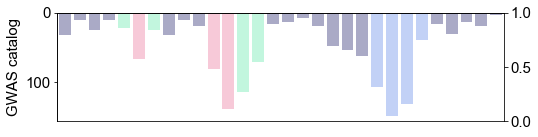

In [76]:
plt.rcParams["figure.figsize"] = (8,2)
plt.rcParams["font.size"] = 15
plt.rcParams['font.family']='Arial'

ax=sns.barplot(x='index',y='gene_name',data=phewas_data_2d_columns_catalog_all_count,palette=list(phewas_data_2d_columns_catalog_all_count['color'].values),alpha=0.5)
#sns.barplot(x='index',y='gene_name',data=phewas_data_2d_columns_catalog_all_count,palette=list(phewas_data_2d_columns_catalog_all_count['color'].values),alpha=0.5)



#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)
ax.xaxis.set_visible(False)
plt.xticks(fontsize=5)
plt.gca().invert_yaxis()
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.ylabel('GWAS catalog')
#plt.xlabel('ss')

ax2 = ax.twinx() 
ax2=sns.barplot(x='gene',y=0,data=phewas_data_2d_count,palette=list(phewas_data_2d_count['color'].values),alpha=0.7)
plt.gca().invert_yaxis()
ax2.spines['bottom'].set_visible(False)
plt.ylabel('our result')

plt.savefig('figure_phewas2.svg', bbox_inches='tight')

In [77]:
phewas_data_2d_noveltycheck=phewas_data_2d.copy()

In [78]:
novelty_check_df[(novelty_check_df['PUBMEDID']=='OUR_RESULT')&(novelty_check_df['phenotype_name']=='hematocrit')]#['GENE_CUSTOM_REPORTED_GENE_CUSTOM'].values

,phenotype_name,PUBMEDID,DISEASE/TRAIT,MAPPED_TRAIT,SNPS,CHR_POS,REPORTED GENE(S),GENE_CUSTOM_REPORTED_GENE_CUSTOM,genehow,novelty,phenotype_category,phenotype_type,phenotype_name_publication
74,hematocrit,OUR_RESULT,NaN,NaN,6:32149801_C/T,32149801.0,NaN,"RNF5,AGER",on_gene,novel,Hematological QTL,continuous,Hematocrit
75,hematocrit,OUR_RESULT,NaN,NaN,SNPS_B_836_31324100_exon3,31324100.0,NaN,HLA-B,on_gene,-,Hematological QTL,continuous,Hematocrit
76,hematocrit,OUR_RESULT,NaN,NaN,6:29698050_A/G,29698050.0,NaN,HLA-F,on_gene,novel,Hematological QTL,continuous,Hematocrit


In [79]:
phewas_data_2d_noveltycheck=phewas_data_2d.copy()

for row, row_data in phewas_data_2d_noveltycheck.iterrows():
    for col,element in row_data.items():
        #print(row,co)
        if ~np.isnan(element):
            if ((row=='hematocrit') and (col=='RNF5' or col=='AGER')) or (col in novelty_check_df[(novelty_check_df['PUBMEDID']=='OUR_RESULT')&(novelty_check_df['phenotype_name']==row)&(novelty_check_df['novelty']=='novel')]['GENE_CUSTOM_REPORTED_GENE_CUSTOM'].values):
                phewas_data_2d_noveltycheck.loc[row,col]=1
                print(row,col)
            else:
                phewas_data_2d_noveltycheck.loc[row,col]=np.nan

blood_in_urine HLA-A
thyroid_disease MICB
thyroid_disease BAG6
grip_strength MICA
height HLA-F
height TCF19
hip_circumference C6orf100
hip_circumference HLA-DRB1
weight TRIM27
weight MUC22
weight HLA-DQA1
diastolic_blood_pressure NOTCH4
systolic_blood_pressure NOTCH4
hematocrit HLA-F
hematocrit RNF5
hematocrit AGER
hemoglobin C2,ZBTB12
platelet HLA-DRB1
platelet HMGA1
rbc HLA-A
rbc ATF6B
bun HLA-E
creatinine HLA-C
creatinine MICA
alt MICA
alt HMGA1
ast HLA-DRB1
ast HLA-DPB1
hdl_cholesterol BTNL2
hdl_cholesterol UHRF1BP1
triglyceride HMGA1
menopause_age HLA-DRB1
pulse UBD
albumin POU5F1
albumin C6orf1
hscrp MICB


In [88]:
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from matplotlib import cm
import matplotlib.pyplot as plt

#custom_cmap=cm.get_cmap('rainbow')
#custom_cmap_array=custom_cmap(np.linspace(0.3, 1, 100))

rgba_array=[(190,235,256,256),
            (110,150,220,256),
            (26,42,180,256),
            (30,128,30,256),
            (249,206,20,256),
            (231,51,132,256)]
cutidx_array=np.array([160,330,500,667,830,1000])

custom_cmap_array=[]

for idx in range(1000):
    custom_cmap_array.append(
        rgba_array[np.argmax((cutidx_array-idx)>0)]
    )
    
custom_cmap_array=np.array(custom_cmap_array)/256
print(custom_cmap_array.shape)
"""        
for idx,_ in enumerate(idx_thres[:-1:]):
    
    custom_cmap_array[idx_thres[idx]:idx_thres[idx+1],:]=custom_cmap_array[idx_thres[idx+1]-1]
    if idx==0:
        custom_cmap_array[idx_thres[idx]:idx_thres[idx+1],:-1]=2*custom_cmap_array[idx_thres[idx]:idx_thres[idx+1],:-1]
"""
#custom_cmap_array[:30,:3]=custom_cmap_array[:30,:3]*np.linspace(3, 1, 30).reshape((-1,1))
#custom_cmap_array=np.array([[min(rgba[0]+0.1,1),min(rgba[1]+0.1,1),min(rgba[2]+0.1,1),rgba[3]] for rgba in custom_cmap_array])
#custom_cmap_array=np.concatenate([np.array([[1,1,1,1]]*100),custom_cmap_array],axis=0)
#custom_cmap_array=np.array([[min(rgba[0]+0.1,1),min(rgba[1]+0.1,1),min(rgba[2]+0.1,1),rgba[3]] for rgba in custom_cmap_array])
#custom_cmap_array[0][-1]=0
#custom_cmap_array[0]=[0.8,0.8,1,1]
#custom_cmap_array[0]=custom_cmap_array[0]*2
#custom_cmap_array=
#custom_cmap_array=[custom_cmap_array[0],custom_cmap_array[20],custom_cmap_array[40],custom_cmap_array[60]]

#custom_cmap_array=custom_cmap_array[30:]
custom_cmap = ListedColormap(custom_cmap_array)

(1000, 4)


In [621]:
phenotype_category_color=pd.Series(index=phenotype_info.loc[phewas_data_2d.index]['phenotype_category'].unique())
cnt=1
for phenotype_category,row in phenotype_category_color.items():
    if 'Other' in phenotype_category:
        phenotype_category_color[phenotype_category]=0
        
    elif (phenotype_info.loc[phewas_data_2d.index]['phenotype_category']==phenotype_category).sum()==1:
        phenotype_category_color[phenotype_category]=0
    else:
        phenotype_category_color[phenotype_category]=cnt;cnt+=1

cmap_temp=plt.cm.brg(np.linspace(0,1,phenotype_category_color.max()))
cmap_temp=[[color[0]*0.6,color[1]*0.6,color[2]*0.6,color[3]] for color in cmap_temp]
np.random.shuffle(cmap_temp)
cmap_temp=np.concatenate(([[0,0,0,1]],cmap_temp))   

phenotype_category_color=phenotype_category_color.map(lambda x: cmap_temp[int(x)])

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':


In [81]:
def category_to_color(category):
    color=(0,0,0,256)
    if 'Hemato' in category:##
        color=(180,5,5,256)
    elif 'Anthropomet' in category:##
        color=(5,5,180,256)
    elif 'Protein' in category:##
        color=(5,180,5,256)        
        
    elif 'Metabolic' in category:##
        color=(160,120,20,256)
    elif 'Liver' in category:
        color=(120,20,160,256)
    elif 'Kidney' in category:##
        color=(20,120,160,256)
    elif 'Blood-pressure' in category:
        color=(256,50,5,256)
    return np.array(color)/256

In [636]:
26,42,180

array([1., 1., 1., 1.])

In [631]:
phenotype_category_color

Cardiovascular disease                                   [0.0, 0.0, 0.0, 1.0]
Immune-related diseases                                  [0.0, 0.0, 0.0, 1.0]
Kidney-related disease                                   [0.0, 0.0, 0.0, 1.0]
Metabolic diseases          [0.16941176470588235, 0.43058823529411766, 0.0...
Thyroid-related diseases                                 [0.0, 0.0, 0.0, 1.0]
Anthropometric QTL          [0.34352941176470586, 0.0, 0.2564705882352941,...
Blood-pressure QTL                                       [0.0, 0.6, 0.0, 1.0]
Hematological QTL           [0.5129411764705882, 0.08705882352941177, 0.0,...
Kidney-related QTL                                       [0.0, 0.0, 0.6, 1.0]
Liver-related QTL           [0.16941176470588235, 0.0, 0.43058823529411766...
Metabolic QTL               [0.34352941176470586, 0.2564705882352941, 0.0,...
Other QTL                                                [0.0, 0.0, 0.0, 1.0]
Protein QTL                 [0.5129411764705882, 0.0, 0.08705882

In [68]:
def gene_to_color(gene_name):

    if gene_name in ['HLA-A','HLA-B','HLA-C']:
        #color='#fa3c14'
        #250, 58, 20
        color=1/256*np.array((250,58,20,256))
    elif gene_name in ['HLA-DPA1', 'HLA-DPB1','HLA-DQA1', 'HLA-DQB1','HLA-DRB1','HLA-DRA']:
        #color='#2850c8'
        color=1/256*np.array((40, 80, 200,256))
    elif gene_name in ['HLA-F', 'HLA-G', 'HLA-E', 'HLA-DRB5', 'HLA-DQA2', 'HLA-DQB2', 'HLA-DOB', 'HLA-DMB', 'HLA-DMA', 'HLA-DOA', 'MICA','MICB','TAP2','TAP1']:
        #color='#28c828'
        color=1/256*np.array((40, 200, 40,256))
    else:
        #color='#fafac8'
        color=1/256*np.array((250, 250, 200,256))
        color[:3]=color[:3]*0.1
        color=1/256*np.array((0, 0, 0,256))
    return color
    
    

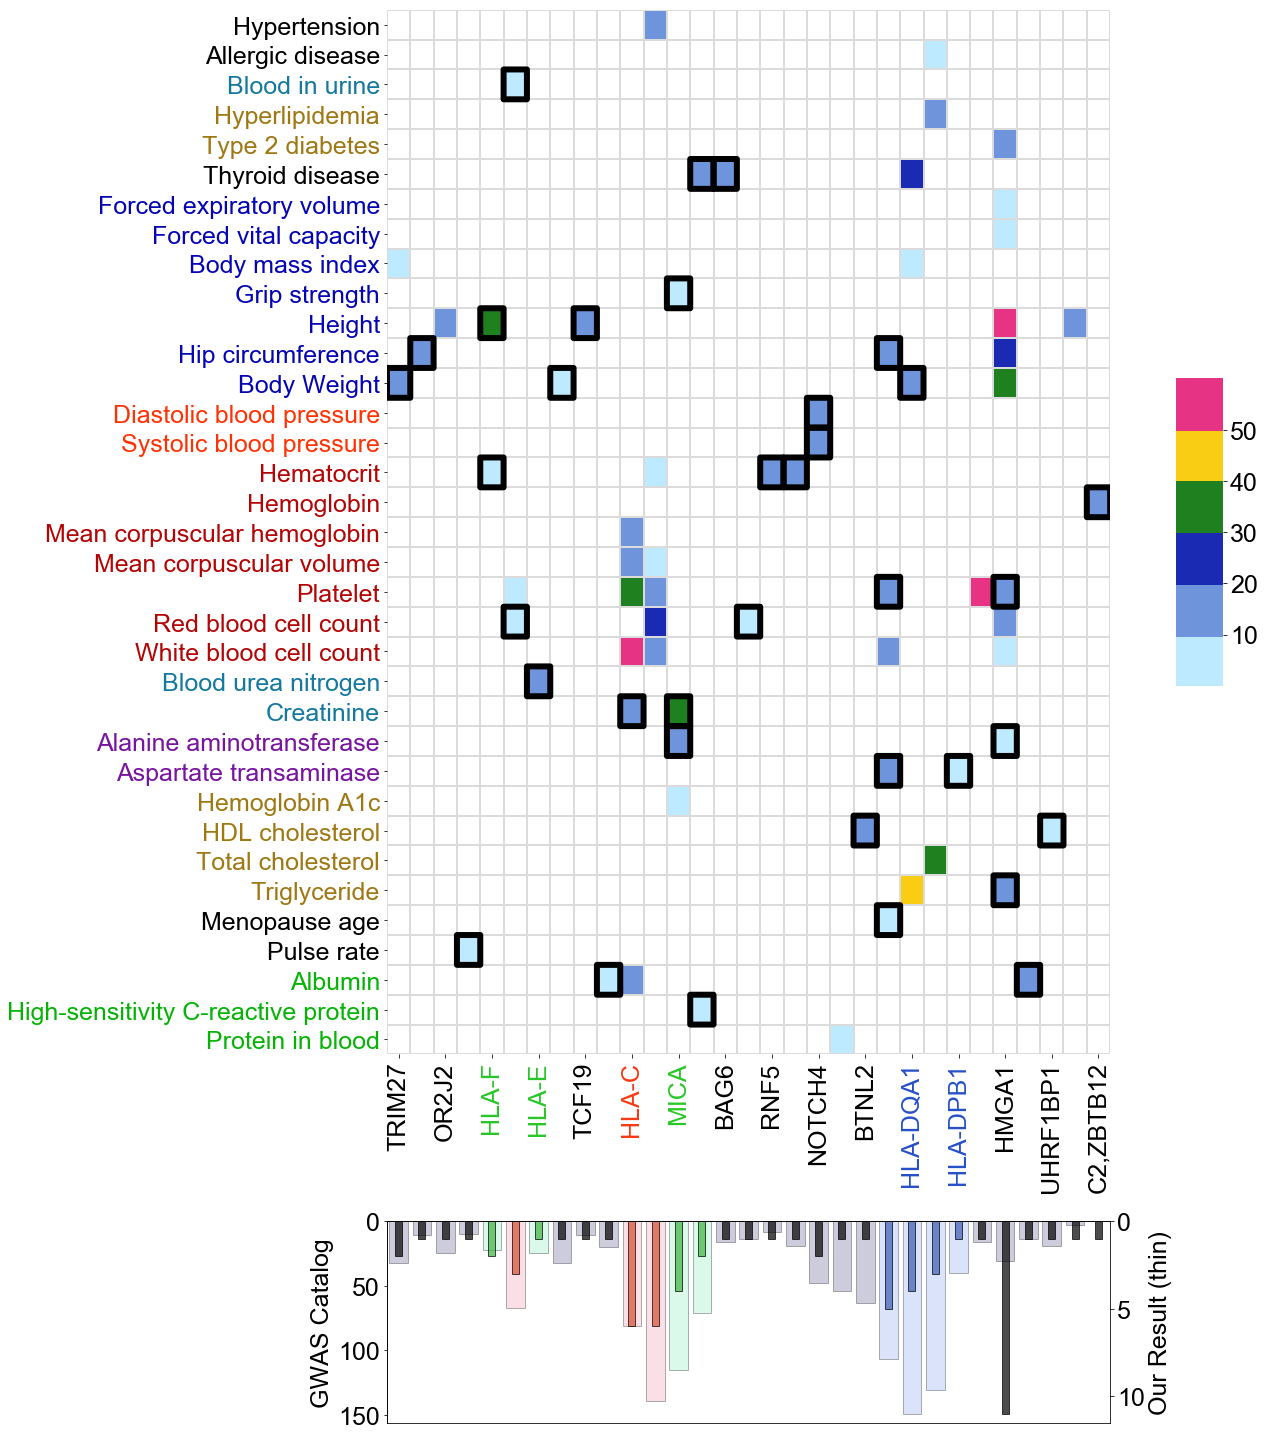

In [89]:
plt.rcParams["figure.figsize"] = (10,15)
plt.rcParams["font.size"] = 25
plt.rcParams['font.family']='Arial'

import matplotlib.gridspec as gridspec
import seaborn as sns

#fig = plt.figure(figsize=(10, 15+3)) 
fig = plt.figure(figsize=(13+1+3, 20+2+4)) 
gs=fig.add_gridspec(20+3+4,13+1+3)



#fig_barplot=fig.add_subplot(gs[20:24,0:13])

#gs = gridspec.GridSpec(3, 2, height_ratios=[5, 0.05, 1], width_ratios=[10,1]) 


fig_heatmap=fig.add_subplot(gs[0:20,0:13])
fig_heatmap_cmap=fig.add_subplot(gs[0+7:20-7, 13+1:13+1+1])


sns.heatmap(phewas_data_2d,
            ax=fig_heatmap,
            cmap=custom_cmap,
            vmin=0,
            vmax=60,
            linewidths=1,
            linecolor=np.array([220,220,220,256])/256,
            cbar_ax=fig_heatmap_cmap,
            cbar_kws={'fraction':0.1, "ticks":[10, 20, 30, 40, 50]},
            cbar=True,
            alpha=1,edgecolor='black')#,legend=None)
#fig.delaxes(fig_heatmap)

fig_heatmap.set_ylabel('')
fig_heatmap.set_xlabel('')

for ticklabel in fig_heatmap.yaxis.get_ticklabels():
    phenotype_name=ticklabel.get_text()
    phenotype_category=phenotype_info.loc[phenotype_name]['phenotype_category']
    ticklabel.set_color(category_to_color(phenotype_category))
fig_heatmap.set_yticklabels([phenotype_info.loc[item.get_text()]['phenotype_name_publication'] for item in fig_heatmap.get_yticklabels()])

for ticklabel in fig_heatmap.xaxis.get_ticklabels():
    gene_name=ticklabel.get_text()
    ticklabel.set_color(gene_to_color(gene_name))


custom_cmap_white = ListedColormap([[1,1,1,0],
                                    [1,1,1,0],
                                    [1,1,1,0],
                                   ])    
#ax=sns.heatmap(phewas_data_2d_noveltycheck, ax=ax, cmap=custom_cmap_white, vmin=0, vmax=1, linecolor=None, cbar=False, alpha=0.7)#,legend=None)    
fig_heatmap.pcolor(phewas_data_2d_noveltycheck.values, cmap=custom_cmap_white, facecolor=None, edgecolors='black', linewidths=6)#, ax=ax)    
  
    
    
fig_barplot=fig.add_subplot(gs[20+3:20+3+4,0:13])    
sns.barplot(x='index',y='gene_name',ax=fig_barplot,data=phewas_data_2d_columns_catalog_all_count,
            edgecolor='black',
            palette=list(phewas_data_2d_columns_catalog_all_count['color'].values),alpha=0.3)    
fig_barplot.xaxis.set_visible(False)
fig_barplot.spines['right'].set_visible(False)
fig_barplot.spines['bottom'].set_visible(False)
fig_barplot.set_ylim(fig_barplot.get_ylim()[::-1])
fig_barplot.set_ylabel('GWAS Catalog')

fig_barplot2 = fig_barplot.twinx() 
sns.barplot(x='gene',y=0,data=phewas_data_2d_count,
            edgecolor='black',
            palette=list(phewas_data_2d_count['color'].values),alpha=0.7,ax=fig_barplot2)
fig_barplot2.set_ylim(fig_barplot2.get_ylim()[::-1])
fig_barplot2.set_ylabel('Our Result (thin)')


for bar in fig_barplot2.patches:
    newwidth=0.3
    
    x = bar.get_x()
    width = bar.get_width()
    centre = x + width/2.
    
    bar.set_x(centre - newwidth/2.)
    bar.set_width(newwidth)


plt.savefig('figure_phewas.png', bbox_inches='tight')

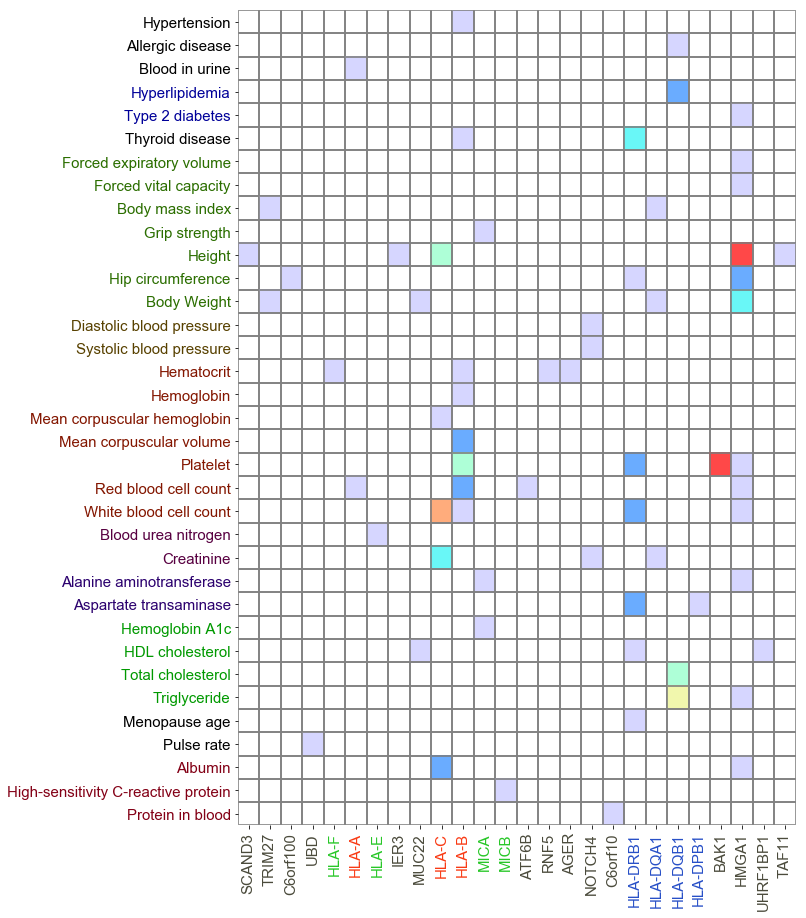

In [377]:
plt.rcParams["figure.figsize"] = (10,15)
plt.rcParams["font.size"] = 15
plt.rcParams['font.family']='Arial'

import seaborn as sns
#ax=sns.heatmap(phewas_data_2d_noveltycheck,cmap=custom_cmap,vmin=0,linewidths=1, linecolor='grey',cbar_kws={"shrink": 0.3,'aspect':15},alpha=0.8)#,legend=None)

#ax=sns.heatmap(phewas_data_2d,cmap=custom_cmap,vmin=-np.log10(5e-8),linewidths=1, linecolor='grey',cbar_kws={"shrink": 0.3,'aspect':15},alpha=0.8)#,legend=None)
ax=sns.heatmap(phewas_data_2d,cmap=custom_cmap,vmin=-np.log10(5e-8),linewidths=1, linecolor='grey',cbar=False, alpha=0.8)#,legend=None)
#ax.legend().set_visible(False)
#ax.legend.
#ax.xaxis.set_ticks_position('top')
#plt.xticks(rotation=90)

plt.ylabel('')
plt.xlabel('')

for ticklabel in ax.yaxis.get_ticklabels():
    phenotype_name=ticklabel.get_text()
    phenotype_category=phenotype_info.loc[phenotype_name]['phenotype_category']
    ticklabel.set_color(phenotype_category_color.loc[phenotype_category])
ax.set_yticklabels([phenotype_info.loc[item.get_text()]['phenotype_name_publication'] for item in ax.get_yticklabels()])

for ticklabel in ax.xaxis.get_ticklabels():
    gene_name=ticklabel.get_text()
    ticklabel.set_color(gene_to_color(gene_name))
    """
    if gene_name in ['HLA-A','HLA-B','HLA-C']:
        ticklabel.set_color('#fa3c14')
    elif gene_name in ['HLA-DPA1', 'HLA-DPB1','HLA-DQA1', 'HLA-DQB1','HLA-DRB1','HLA-DRA']:
        ticklabel.set_color(color='#2850c8')
    elif gene_name in ['HLA-F', 'HLA-G', 'HLA-E', 'HLA-DRB5', 'HLA-DQA2', 'HLA-DQB2', 'HLA-DOB', 'HLA-DMB', 'HLA-DMA', 'HLA-DOA', 'MICA','MICB','TAP2','TAP1']:
        ticklabel.set_color('#28c828')
    """
#plt.show()

plt.savefig('figure_phewas.svg', bbox_inches='tight')

In [989]:
plt.rcParams["figure.figsize"] = (10,15)
plt.rcParams["font.size"] = 15
plt.rcParams['font.family']='Arial'

import matplotlib.gridspec as gridspec
import seaborn as sns

fig = plt.figure(figsize=(10, 15)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1]) 





ax=plt.subplot(gs[0])

ax=sns.heatmap(phewas_data_2d,cmap=custom_cmap,vmin=-np.log10(5e-8),linewidths=1, linecolor='grey',cbar_kws={"shrink": 0.3,'aspect':15},alpha=0.8)#,legend=None)
#ax.legend().set_visible(False)
#ax.legend.
#ax.xaxis.set_ticks_position('top')
#plt.xticks(rotation=90)

plt.ylabel('')
plt.xlabel('')

for ticklabel in ax.yaxis.get_ticklabels():
    phenotype_name=ticklabel.get_text()
    phenotype_category=phenotype_info.loc[phenotype_name]['phenotype_category']
    ticklabel.set_color(phenotype_category_color.loc[phenotype_category])
ax.set_yticklabels([phenotype_info.loc[item.get_text()]['phenotype_name_publication'] for item in ax.get_yticklabels()])

for ticklabel in ax.xaxis.get_ticklabels():
    gene_name=ticklabel.get_text()
    ticklabel.set_color(gene_to_color(gene_name))
    
  



ax=plt.subplot(gs[1])
    
    
#ax=
sns.barplot(x='index',y='gene_name',ax=ax,data=phewas_data_2d_columns_catalog_all_count,palette=list(phewas_data_2d_columns_catalog_all_count['color'].values),alpha=0.5)
#sns.barplot(x='index',y='gene_name',data=phewas_data_2d_columns_catalog_all_count,palette=list(phewas_data_2d_columns_catalog_all_count['color'].values),alpha=0.5)

#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)
ax.xaxis.set_visible(False)
plt.xticks(fontsize=5)
plt.gca().invert_yaxis()
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.ylabel('GWAS catalog')
#plt.xlabel('ss')

ax2 = ax.twinx() 
ax2=sns.barplot(x='gene',y=0,data=phewas_data_2d_count,palette=list(phewas_data_2d_count['color'].values),alpha=0.7)
plt.gca().invert_yaxis()
ax2.spines['bottom'].set_visible(False)
plt.ylabel('our result')    


,phenotype_name_publication,phenotype_category,phenotype_type
phenotype_name,,,
bladder_cancer,Bladder cancer,Cancer,binary
breast_cancer,Breast cancer,Cancer,binary
cervical_cancer,Cervical cancer,Cancer,binary
colorectal_cancer,Colorectal cancer,Cancer,binary
liver_cancer,Liver cancer,Cancer,binary
lung_cancer,Lung cancer,Cancer,binary
prostate_cancer,Prostate cancer,Cancer,binary
stomach_cancer,Stomach cancer,Cancer,binary
thyroid_cancer,Thryroid cancer,Cancer,binary


Index(['hypertension', 'allergic_disease', 'blood_in_urine', 'diabetes',
       'hyperlipidemia', 'thyroid_disease', 'FEV_predicted', 'FVC_predicted',
       'bmi', 'grip_strength', 'height', 'hip_circumference', 'weight',
       'diastolic_blood_pressure', 'systolic_blood_pressure', 'hematocrit',
       'hemoglobin', 'mch', 'mcv', 'platelet', 'rbc', 'wbc', 'bun',
       'creatinine', 'alt', 'ast', 'hba1c', 'hdl_cholesterol',
       'total_cholesterol', 'triglyceride', 'menopause_age', 'pulse',
       'albumin', 'hscrp', 'protein_in_blood'],
      dtype='object', name='phenotype_name')

In [450]:
phenotype_info.sort_values(['phenotype_type','phenotype_category'])#.sort_values('phenotype_category')

,phenotype_name_publication,phenotype_category,phenotype_type
phenotype_name,,,
bladder_cancer,Bladder cancer,Cancer,binary
breast_cancer,Breast cancer,Cancer,binary
cervical_cancer,Cervical cancer,Cancer,binary
colorectal_cancer,Colorectal cancer,Cancer,binary
liver_cancer,Liver cancer,Cancer,binary
lung_cancer,Lung cancer,Cancer,binary
prostate_cancer,Prostate cancer,Cancer,binary
stomach_cancer,Stomach cancer,Cancer,binary
thyroid_cancer,Thryroid cancer,Cancer,binary


In [443]:
gene_bed.set_index('Gene name').loc[phewas_data_2d.columns].sort_values('Gene start (bp)').index#.index#.duplicated().sum()

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


Index(['SCAND3', 'TRIM27', 'C6orf100', 'UBD', 'HLA-F', 'HLA-A', 'HLA-E',
       'IER3', 'MUC22', 'HLA-C', 'HLA-B', 'MICA', 'MICB', 'ATF6B', 'NOTCH4',
       'C6orf10', 'HLA-DRB5', 'HLA-DRB1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DPB1',
       'BAK1', 'HMGA1', 'UHRF1BP1', 'TAF11', 'RNF5,AGER'],
      dtype='object', name='gene')

Index(['ATF6B', 'BAK1', 'C6orf10', 'C6orf100', 'HLA-A', 'HLA-B', 'HLA-C',
       'HLA-DPB1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DRB1', 'HLA-DRB5', 'HLA-E',
       'HLA-F', 'HMGA1', 'IER3', 'MICA', 'MICB', 'MUC22', 'NOTCH4',
       'RNF5,AGER', 'SCAND3', 'TAF11', 'TRIM27', 'UBD', 'UHRF1BP1'],
      dtype='object', name='gene')

In [408]:
phewas_data['count']=1

In [410]:
phewas_data.pivot('count')

KeyError: None

In [333]:
#catalog_chr6_short[catalog_chr6_short['DISEASE/TRAIT'].str.contains('hemoglobin')]

In [328]:
catalog_temp.columns

Index(['Allele', 'CHR_POS', 'CNV', 'CONTEXT', 'Category', 'DISEASE/TRAIT',
       'DOWNSTREAM_GENE_DISTANCE', 'DOWNSTREAM_GENE_ID', 'INITIAL SAMPLE SIZE',
       'INTERGENIC', 'MAPPED_GENE', 'MAPPED_TRAIT', 'P-VALUE',
       'P-VALUE (TEXT)', 'PUBMEDID', 'REPORTED GENE(S)', 'SNPS',
       'SNP_GENE_IDS', 'SNP_ID_CURRENT', 'STUDY', 'UPSTREAM_GENE_DISTANCE',
       'UPSTREAM_GENE_ID', 'GENE_CUSTOM', 'REPORTED_GENE_CUSTOM',
       'GENE_CUSTOM_REPORTED_GENE_CUSTOM'],
      dtype='object')

In [320]:
result_all[result_all['phenotype_name']=='hscrp']

,Unnamed: 0,Unnamed: 0.1,phenotype_name,samples(case/control),step,condition,marker_name,note,term,POS,...,Z,coef,std,chisq,df,P,P_significant,gene_genehow,gene,genehow
87,33113,264088,hscrp,99904,1,NaN,6:31538497_T/A,unphased bialleic,ADD,31538497,...,-5.82507,-0.004091,0.000702,NaN,NaN,5.726200e-09,1,"('LTA', 'nearest')",LTA,nearest
88,32121,288171,hscrp,99904,2,6:31538497_T/A,6:31442731_T/A,unphased bialleic,ADD,31442731,...,-4.79197,-0.003449,0.000720,NaN,NaN,1.653840e-06,0,NaN,NaN,NaN


In [311]:
31371356-31347274,31347274-31321649

(24082, 25625)

In [ ]:
31538497_

In [316]:
gene_bed[gene_bed['Gene name']=='TAP1'].iloc[0]

Gene stable ID                                                                  ENSG00000168394
Gene stable ID version                                                        ENSG00000168394.9
Transcript stable ID                                                            ENST00000354258
Transcript stable ID version                                                  ENST00000354258.4
Gene start (bp)                                                                        32812986
Gene end (bp)                                                                          32821755
Transcript start (bp)                                                                  32812986
Transcript end (bp)                                                                    32821755
Protein stable ID                                                               ENSP00000346206
Protein stable ID version                                                     ENSP00000346206.4
Gene description                        

In [313]:
gene_bed[gene_bed['Gene description'].str.contains('MHC')]

,Gene stable ID,Gene stable ID version,Transcript stable ID,Transcript stable ID version,Gene start (bp),Gene end (bp),Transcript start (bp),Transcript end (bp),Protein stable ID,Protein stable ID version,...,Transcript count,Source of transcript name,Transcript name,Source of gene name,Gene name,GENCODE basic annotation,Transcript length (including UTRs and CDS),Gene stable ID38,Gene start (bp)38,Gene end (bp)38
2123096,ENSG00000204520,ENSG00000204520.8,ENST00000449934,ENST00000449934.2,31371356,31383092,31371356,31383092,ENSP00000413079,ENSP00000413079.1,...,2,HGNC transcript name,MICA-001,HGNC Symbol,MICA,1.0,1386,ENSG00000204520,31399784.0,31415315.0
2123486,ENSG00000204516,ENSG00000204516.5,ENST00000399150,ENST00000399150.3,31462658,31478901,31465863,31478901,ENSP00000382103,ENSP00000382103.3,...,5,HGNC transcript name,MICB-002,HGNC Symbol,MICB,1.0,2346,ENSG00000204516,31494881.0,31511124.0
4062867,ENSG00000204290,ENSG00000204290.6,ENST00000454136,ENST00000454136.3,32361740,32374905,32361740,32374905,ENSP00000390613,ENSP00000390613.3,...,9,HGNC transcript name,BTNL2-001,HGNC Symbol,BTNL2,1.0,1460,ENSG00000204290,32393963.0,32407128.0


In [322]:
gene_bed.loc[(gene_bed['Gene start (bp)']-31538497).abs().sort_values().index]

,Gene stable ID,Gene stable ID version,Transcript stable ID,Transcript stable ID version,Gene start (bp),Gene end (bp),Transcript start (bp),Transcript end (bp),Protein stable ID,Protein stable ID version,...,Transcript count,Source of transcript name,Transcript name,Source of gene name,Gene name,GENCODE basic annotation,Transcript length (including UTRs and CDS),Gene stable ID38,Gene start (bp)38,Gene end (bp)38
2187189,ENSG00000226979,ENSG00000226979.4,ENST00000454783,ENST00000454783.1,31539831,31542101,31539831,31542101,ENSP00000403495,ENSP00000403495.1,...,4,HGNC transcript name,LTA-002,HGNC Symbol,LTA,1.0,1507,ENSG00000226979,31572054.0,31574324.0
2187777,ENSG00000232810,ENSG00000232810.3,ENST00000449264,ENST00000449264.2,31543344,31546113,31543344,31546113,ENSP00000398698,ENSP00000398698.2,...,1,HGNC transcript name,TNF-001,HGNC Symbol,TNF,1.0,1676,ENSG00000232810,31575565.0,31578336.0
2187949,ENSG00000227507,ENSG00000227507.2,ENST00000429299,ENST00000429299.2,31548302,31550299,31548332,31550202,ENSP00000410481,ENSP00000410481.2,...,4,HGNC transcript name,LTB-001,HGNC Symbol,LTB,1.0,897,ENSG00000227507,31580525.0,31582522.0
2188273,ENSG00000204482,ENSG00000204482.6,ENST00000418507,ENST00000418507.2,31553901,31556686,31553901,31556686,ENSP00000405900,ENSP00000405900.2,...,24,HGNC transcript name,LST1-011,HGNC Symbol,LST1,1.0,726,ENSG00000204482,31586124.0,31588909.0
2205633,ENSG00000204475,ENSG00000204475.5,ENST00000340027,ENST00000340027.5,31556672,31560762,31556672,31560762,ENSP00000342156,ENSP00000342156.5,...,6,HGNC transcript name,NCR3-001,HGNC Symbol,NCR3,1.0,1042,ENSG00000204475,31588895.0,31593006.0
2186467,ENSG00000204498,ENSG00000204498.6,ENST00000376146,ENST00000376146.4,31514647,31526606,31514647,31526606,ENSP00000365316,ENSP00000365316.4,...,5,HGNC transcript name,NFKBIL1-003,HGNC Symbol,NFKBIL1,NaN,1411,ENSG00000204498,31546870.0,31558829.0
2185022,ENSG00000213760,ENSG00000213760.6,ENST00000376151,ENST00000376151.4,31512239,31516204,31512239,31514414,ENSP00000365321,ENSP00000365321.4,...,6,HGNC transcript name,ATP6V1G2-002,HGNC Symbol,ATP6V1G2,1.0,1261,ENSG00000213760,31544462.0,31548427.0
2127794,ENSG00000198563,ENSG00000198563.9,ENST00000376177,ENST00000376177.2,31497996,31510225,31497996,31508313,ENSP00000365347,ENSP00000365347.2,...,25,HGNC transcript name,DDX39B-006,HGNC Symbol,DDX39B,1.0,1529,ENSG00000198563,31530219.0,31542448.0
2123980,ENSG00000204511,ENSG00000204511.2,ENST00000376191,ENST00000376191.2,31496494,31498009,31496494,31498009,ENSP00000365362,ENSP00000365362.2,...,1,HGNC transcript name,MCCD1-001,HGNC Symbol,MCCD1,1.0,955,ENSG00000204511,31528962.0,31530232.0
2207335,ENSG00000204472,ENSG00000204472.8,ENST00000376059,ENST00000376059.3,31582961,31584798,31582961,31584798,ENSP00000365227,ENSP00000365227.3,...,5,HGNC transcript name,AIF1-001,HGNC Symbol,AIF1,1.0,711,ENSG00000204472,31615217.0,31617021.0


In [314]:
'TAP1' in gene_bed['Gene name'].values

True

In [65]:
gene_to_name=lambda x: gene_bed_indexed.loc[x.split(',')] if type(x)==str else x

catalog_chr6_short['SNP_GENE_IDS'].map(gene_to_name)

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


KeyError: "None of [Index(['ENSG00000206337'], dtype='object', name='Gene stable ID')] are in the [index]"

In [ ]:
for idx,row in catalog_chr6_short.iterrows():
    print(row['DISEASE/TRAIT'],'-----',row['MAPPED_TRAIT'])
    
    if idx==1000:
        break

In [55]:
catalog_chr6_short['DISEASE/TRAIT'].unique()

array(["Crohn's disease", 'Ulcerative colitis',
       'Alcohol consumption (transferrin glycosylation)', ...,
       'Educational attainment (MTAG)', 'Cognitive performance (MTAG)',
       'Self-reported math ability'], dtype=object)

In [56]:
catalog_chr6_short['MAPPED_TRAIT'].unique()

array(["Crohn's disease", 'ulcerative colitis', 'alcohol drinking', ...,
       'chronic kidney disease, APOL1 risk genotype carrier status',
       'Microalbuminuria, type I diabetes mellitus',
       'response to ketogenic diet, epilepsy'], dtype=object)

In [ ]:
catalog_chr6_short[catalog_chr6_short['DOWNSTREAM_GENE_DISTANCE'].isnull()]